In [83]:
import scipy as sp
import scipy.stats as sps
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import seaborn as sns
import jenkspy as jp
import math
from sklearn.manifold import MDS
from itertools import pairwise, combinations

In [84]:
NUM_VARS = 4
NUM_SETS = 6
NUM_SECTORS = 3

var_stats = {"mean": np.repeat(0, NUM_VARS), "sd": np.repeat(0.5, NUM_VARS)}
set_stats = [
    0.5,
    0.25,
    0.15,
    0.1,
    0.1,
    0.1,
]  # from imdb dataset then rounded to next .05
# original data
# 0.46,
# 0.25,
# 0.16,
# 0.11,
# 0.1,
# 0.09,

var_names = list(map(lambda i: f"V{i}", range(NUM_VARS)))  # raw value
varz_names = list(
    map(lambda vn: f"{vn}_z", var_names)
)  # min-max normalized value (for glyph drawing, perhaps)
varb_names = list(
    map(lambda vn: f"{vn}_b", var_names)
)  # fisher-jenks bin (also for glyph drawing)

set_names = list(map(lambda i: f"S{i}", range(NUM_SETS)))

In [85]:
def mvnorm(means, sds, size=10, random_state=None):
    dist = sps.multivariate_normal(means, sds)
    return dist.rvs(size=size, random_state=random_state)


def uniform(loc=0, scale=1, size=10, random_state=None):
    dist = sps.uniform(loc=loc, scale=scale)
    return dist.rvs(size=size, random_state=random_state)


def rvs(means, sds, limits, size=10, random_state=None):
    """Returns samples of D truncated normal distributions with the provided means, SDs and limits.
    The distributions are assumed to be independent, hence each dimension is sampled individually.
    The provided limits are assumed to be in sample space (as opposed to standard deviations).
    Note that SD and limits are dependent, i.e., if the limits are too narrow, the SD of the resulting
    distribution will be smaller than what was asked for."""
    D = min(len(means), len(sds), len(limits))
    result = np.empty((size, D))
    for i in range(D):
        l = limits[i][0]
        r = limits[i][1]
        m = means[i]
        s = sds[i]
        a, b = (l - m) / s, (r - m) / s
        samples = sps.truncnorm.rvs(
            a, b, loc=m, scale=s, size=size, random_state=random_state
        )
        result[:, i] = samples
    return result

In [96]:
means = var_stats["mean"]
sds = var_stats["sd"]


def norm(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))


def get_scale_from_shift_dir(dir, margin=0):
    return 1 / NUM_SECTORS - 2 * margin if dir != 0 else 1


def get_loc_from_shift_dir(dir, margin=0):
    if dir <= 1:
        return 0
    return 1 / NUM_SECTORS * (dir - 1) + margin

    """match dir:
        case 0:
            return 0
        case 1:
            return 0
        case 2:
            return 0.2 + margin
        case 3:
            return 0.4 + margin
        case 4:
            return 0.6 + margin
        case 5:
            return 0.8 + margin"""


def value_fits_dir(value, dir):
    if dir == 0:
        return True
    for i in range(1, NUM_SECTORS + 1):
        if dir == i:
            return value >= 1 / NUM_SECTORS * (i - 1) and value < 1 / NUM_SECTORS * i
    return False
    """match dir:
        case 0:
            return True
        case 1:
            return value < 0.2
        case 2:
            return value >= 0.2 and value < 0.4
        case 3:
            return value >= 0.4 and value < 0.6
        case 4:
            return value >= 0.6 and value < 0.8
        case 5:
            return value >= 0.8"""


def make_dataset(
    cluster1_size=20,
    cluster2_size=5,
    # cluster2_shift_direction is a list of length NUM_VARS. a 0 indicates no shift, any number above means the desired sector in a star glyph
    cluster2_shift_direction=[],
    sector_margin=0.05,
):
    cluster_defining_vars = list(
        [(i, d) for i, d in enumerate(cluster2_shift_direction) if d != 0]
    )
    samples1 = np.transpose(
        np.array(
            [
                random.choices(range(NUM_SECTORS), k=cluster1_size)
                for i in range(NUM_VARS)
            ]
        )
    )
    samples2 = np.transpose(
        np.array(
            [
                (
                    random.choices(range(NUM_SECTORS), k=cluster2_size)
                    if cluster2_shift_direction[i] == 0
                    else random.choices([cluster2_shift_direction[i]], k=cluster2_size)
                )
                for i in range(NUM_VARS)
            ]
        )
    )

    # go through cluster 1 and make sure that no data point has the same characteristics that define cluster 2
    for j in range(samples1.shape[0]):
        while all([samples1[j, v] == dir for v, dir in cluster_defining_vars]):
            for v, _ in cluster_defining_vars:
                samples1[j, v] = random.choice(range(NUM_SECTORS))

    samples = np.concatenate((samples1, samples2))

    data = {}
    for i in range(NUM_VARS):
        x = samples[:, i]
        xz = norm(x)
        data[f"V{i}"] = x
        data[f"V{i}_z"] = xz
        data[f"V{i}_b"] = x + 1

    data["cluster"] = np.concatenate(
        (np.repeat(0, cluster1_size), np.repeat(1, cluster2_size))
    )
    df = pd.DataFrame(data=data)

    local_set_stats = [stat for stat in set_stats]
    random.shuffle(local_set_stats)
    for i in range(NUM_SETS):
        freq = local_set_stats[i]
        df[f"S{i}"] = sps.binom.rvs(1, freq, size=cluster1_size + cluster2_size)

    # now a bit of postprocessing regarding sets
    set_names = list(map(lambda i: f"S{i}", range(NUM_SETS)))
    """
    # we want all sets to have at least one element in each cluster
    # which at the same time ensures that no set has a single or no element
    genre_colsums = df[set_names + ["cluster"]].groupby("cluster").sum()
    for cluster in range(2):
        for genre in set_names:
            count = genre_colsums.loc[cluster, genre]
            if count == 0:
                # take random row of that cluster and add the set there
                randrow_start = 0 if cluster == 0 else cluster1_size
                randrow_end = (
                    cluster1_size if cluster == 0 else cluster1_size + cluster2_size
                )
                randrow = np.random.choice(
                    range(randrow_start, randrow_end), 1, replace=False
                )
                df.loc[randrow[0], genre] = 1
    """
    # there could be movies not in any set/genre, and we don't want that
    # ensure row sums are at least 1
    for i in range(df.shape[0]):
        while df.loc[i][set_names].sum() < 1:
            for j, genre in enumerate(set_names):
                # do the drawing again
                freq = local_set_stats[j]
                flag = sps.binom.rvs(1, freq, size=1)
                df.loc[i, genre] = flag
    # there could be genres with only one movie, and we don't want that
    # ensure col sums are at least 2 (so that lines actually work as visual idiom)
    for j, genre in enumerate(set_names):
        while df[genre].sum(axis=0) < 2:
            rowids = list(range(cluster1_size + cluster2_size))
            randrow = random.sample(range(len(rowids)), 1)[0]
            randrow = rowids.pop(randrow)
            df.loc[randrow, genre] = sps.binom.rvs(1, local_set_stats[j], size=1)
    # for later: at least 1 genre has to have >=2 movies in cluster 2 and >=1 in cluster 1
    at_least_two_movies_in_2 = lambda s: df[df["cluster"] == 1][s].sum() >= 2
    at_least_one_movie_in_1 = lambda s: df[df["cluster"] == 0][s].sum() >= 1
    if not any(
        [at_least_two_movies_in_2(s) and at_least_one_movie_in_1(s) for s in set_names]
    ):
        # ok so there is no set with these properties
        # make this easy: find a set that has 1 in each cluster and add random element from cluster 2
        s = random.choice(
            [
                s
                for s in set_names
                if df[df["cluster"] == 0][s].sum() >= 1
                and df[df["cluster"] == 1][s].sum() >= 1
            ]
        )
        rowid = random.choice(
            [
                i
                for i in range(df.shape[0])
                if df.loc[i]["cluster"] == 1 and df.loc[i][s] == 0
            ]
        )
        df.loc[rowid, s] == 1
    assert any(
        [at_least_two_movies_in_2(s) and at_least_one_movie_in_1(s) for s in set_names]
    ), "precondition failed"

    return df

In [102]:
dataset = make_dataset(
    cluster2_shift_direction=[NUM_SECTORS, 1, 0, NUM_SECTORS],
    cluster1_size=36,
    cluster2_size=6,
)
dataset

,V0,V0_z,V0_b,V1,V1_z,V1_b,V2,V2_z,V2_b,V3,V3_z,V3_b,cluster,S0,S1,S2,S3,S4,S5
0,2,0.666667,3,0,0.0,1,1,0.5,2,1,0.333333,2,0,0,1,0,0,0,1
1,2,0.666667,3,0,0.0,1,1,0.5,2,1,0.333333,2,0,1,0,0,0,0,1
2,0,0.000000,1,2,1.0,3,0,0.0,1,0,0.000000,1,0,0,0,1,1,0,0
3,2,0.666667,3,2,1.0,3,1,0.5,2,0,0.000000,1,0,0,0,0,0,0,1
4,1,0.333333,2,0,0.0,1,2,1.0,3,2,0.666667,3,0,0,1,0,0,0,1
5,2,0.666667,3,0,0.0,1,2,1.0,3,0,0.000000,1,0,0,0,0,1,0,0
6,0,0.000000,1,1,0.5,2,0,0.0,1,1,0.333333,2,0,0,0,0,1,0,0
7,2,0.666667,3,0,0.0,1,2,1.0,3,0,0.000000,1,0,0,0,0,0,0,1
8,0,0.000000,1,0,0.0,1,0,0.0,1,1,0.333333,2,0,0,0,0,0,0,1
9,0,0.000000,1,1,0.5,2,1,0.5,2,1,0.333333,2,0,0,0,0,0,1,0


<Axes: xlabel='pca1', ylabel='pca2'>

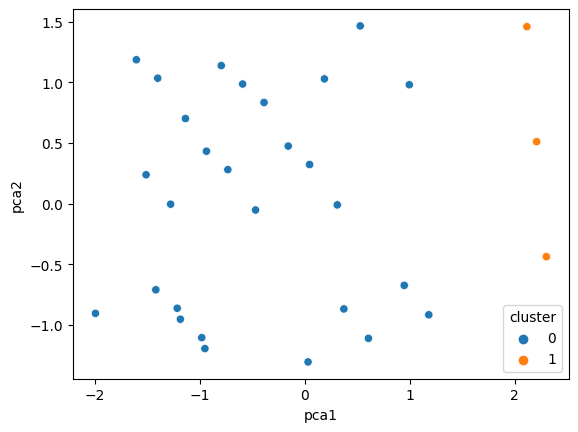

In [88]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
H_pca = pca.fit_transform(dataset[var_names])
sns.scatterplot(
    pd.DataFrame(
        data={
            "pca1": H_pca[:, 0],
            "pca2": H_pca[:, 1],
            "cluster": dataset["cluster"],
        }
    ),
    x="pca1",
    y="pca2",
    hue="cluster",
)

/Users/npiccolotto/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


<Axes: xlabel='mdsx', ylabel='mdsy'>

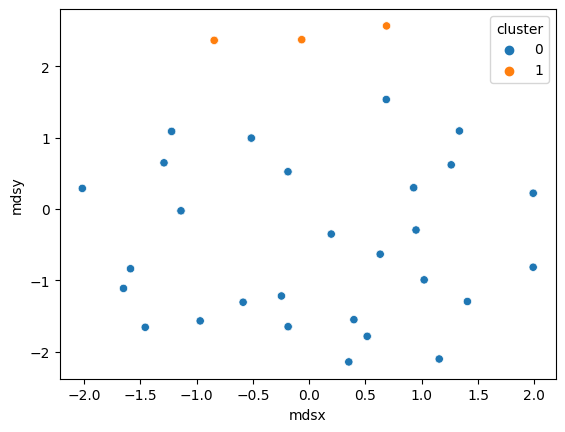

In [93]:
# quickly check the projection - we want the orange points bunched together
mds = MDS(n_components=2, metric=True, dissimilarity="euclidean")
# H_mds = mds.fit_transform(sps.zscore(dataset[varz_names]))
H_mds = mds.fit_transform(dataset[varb_names])

sns.scatterplot(
    pd.DataFrame(
        data={
            "mdsx": H_mds[:, 0],
            "mdsy": H_mds[:, 1],
            "cluster": dataset["cluster"],
        }
    ),
    x="mdsx",
    y="mdsy",
    hue="cluster",
)

In [90]:
import os.path as osp

dpi = 300

GLYPH_TYPE = "nightingale"


def make_glyphs(name, mdf, target_path="eval/dataset"):
    result = []
    yticks = list(range(1, NUM_SECTORS + 1))
    for i in mdf.index:
        datacase = mdf.loc[i]
        angles = [n / float(NUM_VARS) * 2 * math.pi for n in range(NUM_VARS)] + [0]
        values = [datacase[varb_names[j]] for j in range(NUM_VARS)] + [
            datacase[varb_names[0]]
        ]

        if GLYPH_TYPE == "nightingale":
            ax = plt.subplot(111, polar=True)
            ax.figure.patch.set_alpha(0)
            ax.figure.set_size_inches(1, 1)
            ax.set_ylim(bottom=0, top=1)
            ax.set_yticks(yticks)
            ax.set_xticks(
                ((180 / NUM_VARS) + np.linspace(-180, 180, NUM_VARS, endpoint=False))
                * np.pi
                / 180
            )
            ax.set_thetalim(-np.pi, np.pi)
            ax.spines[:].set_linewidth(0.5)
            ax.bar(
                angles,
                values,
                linewidth=0,
                linestyle="solid",
                width=2 * np.pi / NUM_VARS,
                edgecolor="white",
                color="black",
            )

            plt.tick_params(
                grid_linestyle="solid",
                grid_linewidth=3,
                left=False,
                right=False,
                bottom=False,
                top=False,
                labelleft=False,
                labelright=False,
                labelbottom=False,
                labeltop=False,
            )
        else:

            ax = plt.subplot(111, polar=True)
            ax.figure.patch.set_alpha(0)
            ax.figure.set_size_inches(1, 1)
            ax.set_ylim(bottom=0, top=1)
            ax.set_yticks(yticks)
            ax.set_xticks(
                np.pi / 180.0 * np.linspace(180, -180, NUM_VARS, endpoint=False)
            )
            ax.set_thetalim(-np.pi, np.pi)
            ax.spines[:].set_linewidth(0.5)

            ax.plot(angles, values, linewidth=0, linestyle="solid")
            ax.fill(angles, values, "k", alpha=1)

            plt.tick_params(
                grid_linestyle="dashed",
                grid_linewidth=0.5,
                left=False,
                right=False,
                bottom=False,
                top=False,
                labelleft=False,
                labelright=False,
                labelbottom=False,
                labeltop=False,
            )

        plt.tight_layout(pad=-1)
        filename = f"./img/{name}_{i}_thumb.png"
        plt.savefig(filename, dpi=dpi, bbox_inches="tight", transparent=False)
        plt.clf()
        result.append(osp.join(target_path, filename))
    return result

In [112]:
import json
import scipy.spatial.distance as scidist
from itertools import combinations, pairwise, product

NUM_CLUSTER_DEFINING_VARS = 6


# Generate random datasets
# for i in range(27):
def make_complete_dataset(prefix, i, n=20, cluster1_size=15, img_path="eval/dataset/"):
    # generate dataset
    ds_name = f"{prefix}_dataset{i}"
    print(ds_name)
    # this line to randomly pick cluster-defining variables
    # cluster_defining_vars = random.sample(range(NUM_VARS), k=NUM_CLUSTER_DEFINING_VARS)
    # this line to pick cluster-defining variables that are next to each other in the glyph (-> easier reading / pattern recognition)
    cluster_defining_vars = (
        np.repeat(random.randint(0, NUM_VARS - 1), NUM_CLUSTER_DEFINING_VARS)
        + range(NUM_CLUSTER_DEFINING_VARS)
    ) % NUM_VARS
    cluster_defining_starglyph_sections = random.choices(
        range(1, NUM_SECTORS + 1), k=NUM_CLUSTER_DEFINING_VARS
    )
    cluster_definers = zip(cluster_defining_vars, cluster_defining_starglyph_sections)

    shift_direction = np.repeat(0, NUM_VARS)
    for v, d in cluster_definers:
        shift_direction[v] = d

    cluster2_size = n - cluster1_size

    df = make_dataset(
        cluster1_size=cluster1_size,
        cluster2_size=cluster2_size,
        cluster2_shift_direction=shift_direction,
    )
    df.to_csv(f"{ds_name}.csv", index=False)

    # make meta file for user tasks
    # task 1: find 3 most similar glyphs to reference (chosen at random from true cluster). accuracy by ranked dissimilarity
    T1_ref = dataset[dataset["cluster"] == 1].sample(1).index[0]
    # task 2: find glyphs of random set. accuracy by precision/recall.
    T2_ref = random.choice(set_names)  # could think about a min size filter?
    # task 3: find glyphs in intersection. accuracy by precision/recall.
    non_empty_two_intersections = {}
    for sa, sb in combinations(set_names, 2):
        intersection_size = len(dataset[(dataset[sa] == 1) & (dataset[sb] == 1)])
        if intersection_size > 2:
            non_empty_two_intersections[(sa, sb)] = intersection_size
    T3_ref = random.choice(list(non_empty_two_intersections.keys()))
    # task 4: find 3 most similar glyphs to reference that also have one set in common.
    possible_T4_refs = {}
    for i in dataset[dataset["cluster"] == 1].index:
        sets_i = [
            s
            for s in list(
                map(lambda sn: sn if dataset.loc[i, sn] == 1 else None, set_names)
            )
            if s is not None
        ]
        qs = " & ".join(list(map(lambda s: f"({s} == 1)", sets_i)))
        if len(dataset.query(qs)) - 1 > 2:
            possible_T4_refs[i] = len(dataset.query(qs)) - 1
    T4_ref = random.choices(list(possible_T4_refs.keys()), k=1)[0]
    task_df = pd.DataFrame(
        data=[[T1_ref, T2_ref, T3_ref, T4_ref]],
        columns=["T1_ref", "T2_ref", "T3_ref", "T4_ref"],
    )
    task_df.to_csv(f"{ds_name}_tasks.csv", index=False)

    # make glyphs
    glyphs = make_glyphs(ds_name, df, target_path=img_path)

    # make json file for undrground tubes python app
    ds_dists = scidist.squareform(scidist.pdist(df[varb_names], scidist.euclidean))
    set_dists = scidist.squareform(scidist.pdist(df[set_names], scidist.jaccard))

    sets_per_row = []
    for j in df.index:
        sets_per_row.append([g for g in set_names if df.loc[j, g] == 1])

    with open(f"{ds_name}.json", "w", encoding="utf8") as f:
        jsonstr = {
            "glyph_ids": glyphs,
            "E": list(map(lambda x: str(x), df.index.tolist())),
            "EA": ds_dists.tolist(),
            "SR": sets_per_row,
            "S": set_names,
            "SA": set_dists.tolist(),
        }
        json.dump(jsonstr, f, ensure_ascii=False)

In [103]:
NUM_DATASETS = 1
for i in range(NUM_DATASETS):
    s, c1s = 42, 36
    make_complete_dataset("ds", i, s, c1s, img_path="eval/dataset/")

ds_dataset0


<Figure size 100x100 with 0 Axes>

In [113]:
import csv

# create and export csv files necessary for creating the survey and interpreting the responses

NUM_TASKS = 4
conditions = list(product(["opt", "heur"], [0, 0.5, 1]))

# make one dataset per task so that response times are comparable within a task
task_refs = []
for t in range(1, NUM_TASKS + 1):
    make_complete_dataset("ds", t, 42, 36, img_path="eval/dataset/")
    with open(f"./ds_dataset{t}_tasks.csv", "r") as f:
        csvr = csv.DictReader(f, ["T1_ref", "T2_ref", "T3_ref", "T4_ref"])
        _, row = csvr
        task_refs.append(row)

with open("./task_refs.csv", "w") as f:
    csvw = csv.DictWriter(f, ["dataset", "T1_ref", "T2_ref", "T3_ref", "T4_ref"])
    csvw.writeheader()
    for i, ref in enumerate(task_refs):
        csvw.writerow({"dataset": i} | ref)

with open("./questions.csv", "w") as f:
    csvw = csv.DictWriter(f, ["question",'qid', "task", "pipeline", "weight"])
    csvw.writeheader()
    for i, q in enumerate(product(conditions, range(1, NUM_TASKS + 1))):
        csvw.writerow(
            {
                "question": i,
                "qid": f"Q-t:{q[1]}-p:{q[0][0]}-w:{q[0][1]}",
                "task": q[1],
                "pipeline": q[0][0],
                "weight": q[0][1],
            }
        )

ds_dataset1
ds_dataset2
ds_dataset3
ds_dataset4


<Figure size 100x100 with 0 Axes>